# Email spam detection 

## 1. Problem Statement:
   * Consider I am hired in company and they are asking to build a model for classifying the spam mails.
 
## 2. Data:
   * The entire data is provided by the flip robo technologies 

## 3. Evaluation:
   * The evaluation is based on the accuracy score, f1_score, recall_score, confusion_matrix, classification_report
   * Consider If our model reaches the accuracy of 90% or more than that we will proceed with this project
 
## 4. Features:
   * In our data we have **Subject, messages, label** features..
   * The dataset has `2893` records
   * The dataset has `3` features

# Getting tools ready

In [1]:
#importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score,plot_roc_curve


#filtering warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('messages.csv')
df.head()

subject  \
0            job posting - apple-iss research center   
1                                                NaN   
2  query : letter frequencies for text identifica...   
3                                               risk   
4                           request book information   

                                             message  label  
0  content - length : 3386 apple-iss research cen...      0  
1  lang classification grimes , joseph e . and ba...      0  
2  i am posting this inquiry for sergei atamas ( ...      0  
3  a colleague and i are researching the differin...      0  
4  earlier this morning i was on the phone with a...      0

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2893 entries, 0 to 2892
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   subject  2831 non-null   object
 1   message  2893 non-null   object
 2   label    2893 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 67.9+ KB


In [4]:
#Checking for the label value count
df.label.value_counts()

0    2412
1     481
Name: label, dtype: int64

In [5]:
print('The percentage of the label 0 :', round(len(df[df['label']==0])/len(df['label'])*100,2),'%')
print('The percentage of the label 1 :', round(len(df[df['label']==1])/len(df['label'])*100, 2), '%')

The percentage of the label 0 : 83.37 %
The percentage of the label 1 : 16.63 %


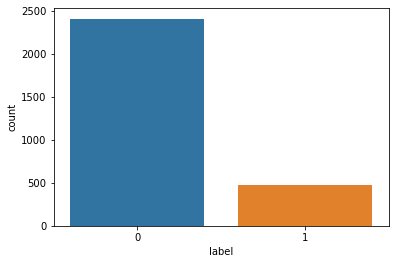

In [6]:
sns.countplot(df['label']);

* This clearly shows that the label `0` is occupying the more space in the dataset so we can tell this as `Imbalanced dataset`.

In [7]:
df['subject'].head(20)

0               job posting - apple-iss research center
1                                                   NaN
2     query : letter frequencies for text identifica...
3                                                  risk
4                              request book information
5     call for abstracts : optimality in syntactic t...
6                   m . a . in scandinavian linguistics
7     call for papers : linguistics session of the m...
8                       foreign language in commercials
9     fulbright announcement : please post / dissemi...
10                          gala ' 95 : call for papers
11    bu conf on language development ' 95 - announc...
12                        korean software for macintosh
13                                                  NaN
14    simultaneous prepositions and postpositions in...
15               sum : imperatives without you subjects
16                                             policies
17    * * * correction to hellenistic greek anno

In [8]:
df.isna().sum()

subject    62
message     0
label       0
dtype: int64

In [9]:
#Dropping the na values as they are comparitively low 
df.dropna(axis = 0, inplace = True)

In [10]:
df.isna().sum()

subject    0
message    0
label      0
dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2831 entries, 0 to 2892
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   subject  2831 non-null   object
 1   message  2831 non-null   object
 2   label    2831 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 88.5+ KB


* There are no missing values in the dataset now

In [12]:
df.head()

subject  \
0            job posting - apple-iss research center   
2  query : letter frequencies for text identifica...   
3                                               risk   
4                           request book information   
5  call for abstracts : optimality in syntactic t...   

                                             message  label  
0  content - length : 3386 apple-iss research cen...      0  
2  i am posting this inquiry for sergei atamas ( ...      0  
3  a colleague and i are researching the differin...      0  
4  earlier this morning i was on the phone with a...      0  
5  content - length : 4437 call for papers is the...      0

In [13]:
#creating the new column with the count of letters in the message
df['length'] = df['message'].str.len()

In [14]:
df.head()

subject  \
0            job posting - apple-iss research center   
2  query : letter frequencies for text identifica...   
3                                               risk   
4                           request book information   
5  call for abstracts : optimality in syntactic t...   

                                             message  label  length  
0  content - length : 3386 apple-iss research cen...      0    2856  
2  i am posting this inquiry for sergei atamas ( ...      0    1435  
3  a colleague and i are researching the differin...      0     324  
4  earlier this morning i was on the phone with a...      0    1046  
5  content - length : 4437 call for papers is the...      0    4492

In [15]:
df.message[0]

"content - length : 3386 apple-iss research center a us $ 10 million joint venture between apple computer inc . and the institute of systems science of the national university of singapore , located in singapore , is looking for : a senior speech scientist - - - - - - - - - - - - - - - - - - - - - - - - - the successful candidate will have research expertise in computational linguistics , including natural language processing and * * english * * and * * chinese * * statistical language modeling . knowledge of state-of - the-art corpus-based n - gram language models , cache language models , and part-of - speech language models are required . a text - to - speech project leader - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - the successful candidate will have research expertise expertise in two or more of the following areas : computational linguistics , including natural language parsing , lexical database design , and statistical language modeling ; text tokenization and

In [16]:
stp_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
def preprocess(data):
    """
    It converts all the aplhabets into lowercase,it will replace the punctuation with space, email addresses as emailaddress, all the non alphabetic values with space, Removes all the default the stop words, lemmatizes with 'WordNetLemmatizer' and returns the data
    """
    #converting all the alphabets into lower case
    data = data.str.lower()
    
    #replacinng all the punctuations values with the space
    data = data.str.replace(r'[^\w\s\d]',' ')
    
    #replacing all the email address with the string 'emailaddress'
    data = data.str.replace(r'\b([A-Z0-9._%-]+)@[A-Z0-9.-]+\.[A-Z]{2,4}\b', 'emailaddress')
    
    #replacing all the non alphabetic values with the space
    data = data.str.replace(r'[0-9]', '')
    
    #removing all the default stop words from the data
    data = data.apply(lambda x : ' '.join(text for text in x.split() if text not in stp_words))
    
    #lemmatizing all the words in the data using wordnet lemmatizer
    data = data.apply(lambda x : ' '.join(lemmatizer.lemmatize(words) for words in word_tokenize(x)))
    
    return data
        

In [17]:
df.message = preprocess(df.message)

In [18]:
df.message[0]

'content length apple i research center u million joint venture apple computer inc institute system science national university singapore located singapore looking senior speech scientist successful candidate research expertise computational linguistics including natural language processing english chinese statistical language modeling knowledge state art corpus based n gram language model cache language model part speech language model required text speech project leader successful candidate research expertise expertise two following area computational linguistics including natural language parsing lexical database design statistical language modeling text tokenization normalization prosodic analysis substantial knowledge phonology syntax semantics chinese required knowledge acoustic phonetics speech signal processing desirable candidate phd least year relevant work experience technical msc degree least year experienc e strong software engineering skill including design implementation

***For subject I will not remove the stopwords as it may lead to form a complete meaningless words***

In [19]:
df.subject[0]

'job posting - apple-iss research center'

In [20]:
def preprocess_subject(data):
    """
    It will convert all the strings into lower case, it will replace the punctuation with the spaces, It will remove the numeric values, it will lemmatize the words using wordnetlemmatizer
    """
    #converting all the alphabets into lower case
    data = data.str.lower()
    
    #replacinng all the punctuations values with the space
    data = data.str.replace(r'[^\w\s\d]',' ')
    
    #replacing all the non alphabetic values with the space
    data = data.str.replace(r'[0-9]', '')
    
    #lemmatizing all the words in the data using wordnet lemmatizer
    data = data.apply(lambda x : ' '.join(lemmatizer.lemmatize(words) for words in word_tokenize(x)))
    
    return data  

In [21]:
df.subject = preprocess_subject(df.subject)

In [22]:
df.subject[0]

'job posting apple i research center'

In [23]:
df.head()

subject  \
0               job posting apple i research center   
2    query letter frequency for text identification   
3                                              risk   
4                          request book information   
5  call for abstract optimality in syntactic theory   

                                             message  label  length  
0  content length apple i research center u milli...      0    2856  
2  posting inquiry sergei atamas satamas umabnet ...      0    1435  
3  colleague researching differing degree risk pe...      0     324  
4  earlier morning phone friend mine living south...      0    1046  
5  content length call paper best good enough wor...      0    4492

In [24]:
df['cleaned_length']= df['message'].str.len()

In [25]:
df.head()

subject  \
0               job posting apple i research center   
2    query letter frequency for text identification   
3                                              risk   
4                          request book information   
5  call for abstract optimality in syntactic theory   

                                             message  label  length  \
0  content length apple i research center u milli...      0    2856   
2  posting inquiry sergei atamas satamas umabnet ...      0    1435   
3  colleague researching differing degree risk pe...      0     324   
4  earlier morning phone friend mine living south...      0    1046   
5  content length call paper best good enough wor...      0    4492   

   cleaned_length  
0            2057  
2             924  
3             207  
4             628  
5            3077

### We can see that the count of words have been reduced

# Data visualization

### Visualization of the spam mail words

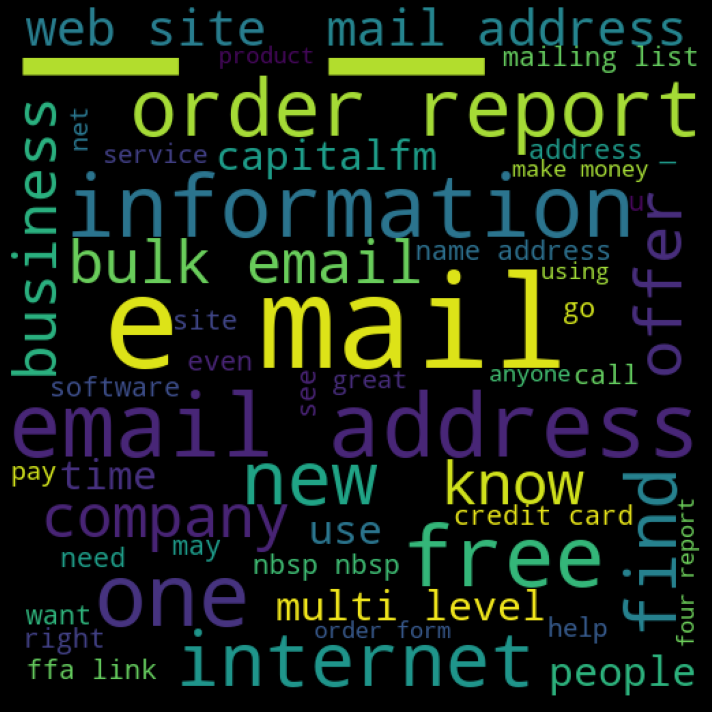

In [26]:
spam_words = df['message'][df['label']==1]
spam_wc = WordCloud(width = 512, height = 512, max_words = 50).generate(' '.join(spam_words))
plt.figure(figsize = (12, 10), facecolor = 'k')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout();

### visualization of non spam mails

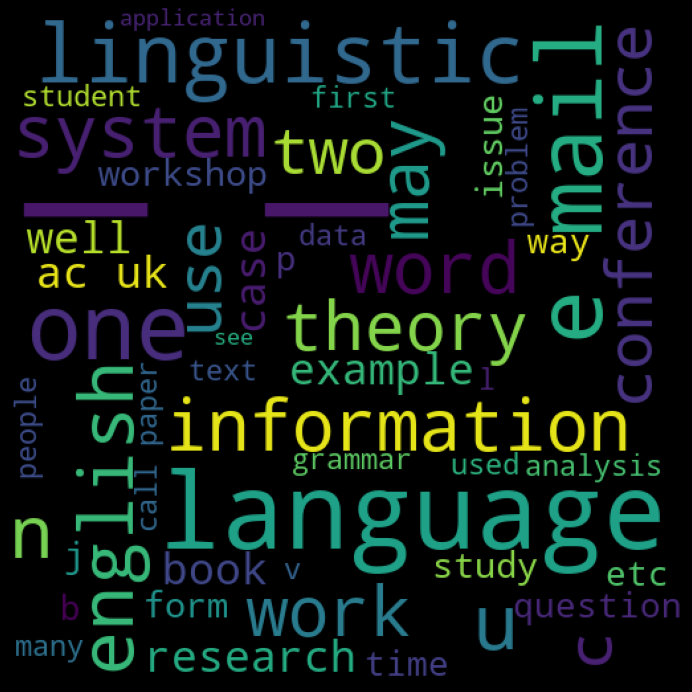

In [27]:
non_spam = df['message'][df['label']==0]
non_spam_wc = WordCloud(width = 512, height = 512, max_words = 50).generate(' '.join(non_spam))
plt.figure(figsize = (12, 10), facecolor = 'k')
plt.imshow(non_spam_wc)
plt.tight_layout()
plt.axis('off');

In [28]:
df.reset_index(inplace = True)

In [29]:
df.drop('index', axis = 1, inplace = True)
df.head()

subject  \
0               job posting apple i research center   
1    query letter frequency for text identification   
2                                              risk   
3                          request book information   
4  call for abstract optimality in syntactic theory   

                                             message  label  length  \
0  content length apple i research center u milli...      0    2856   
1  posting inquiry sergei atamas satamas umabnet ...      0    1435   
2  colleague researching differing degree risk pe...      0     324   
3  earlier morning phone friend mine living south...      0    1046   
4  content length call paper best good enough wor...      0    4492   

   cleaned_length  
0            2057  
1             924  
2             207  
3             628  
4            3077

# Building model

In [30]:
# Initializing tfidvectorizer
tfidf = TfidfVectorizer()

feature1 = tfidf.fit_transform(df['message'], df['subject'])


In [31]:
X = feature1 
y = df['label']

In [32]:
print(tfidf.get_feature_names())

['aa', 'aaa', 'aaai', 'aaal', 'aaarghh', 'aabb', 'aabyhoej', 'aaccess', 'aace', 'aachen', 'aad', 'aae', 'aafarli', 'aafke', 'aafter', 'aag', 'aaghbar', 'aahus', 'aaj', 'aak', 'aakesson', 'aal', 'aala', 'aalborg', 'aale', 'aallan', 'aamodt', 'aamt', 'aan', 'aanbevelingen', 'aanhalingstekens', 'aantal', 'aarbakke', 'aaret', 'aarhus', 'aarne', 'aarno', 'aaron', 'aart', 'aarts', 'aat', 'aatsp', 'aau', 'aave', 'ab', 'aba', 'ababa', 'aback', 'abacus', 'abaitua', 'abajero', 'abancdoned', 'abandon', 'abandoned', 'abandoning', 'abandonment', 'abank', 'abarbanel', 'abarron', 'abaurre', 'abbadingo', 'abbas', 'abbe', 'abbi', 'abbildung', 'abbott', 'abbreaviated', 'abbreviated', 'abbreviates', 'abbreviation', 'abbyy', 'abc', 'abd', 'abdel', 'abdelkader', 'abdellah', 'abdellatif', 'abdelmajid', 'abdelouahab', 'abdesslam', 'abdn', 'abdomen', 'abdu', 'abduction', 'abductive', 'abdul', 'abdulaziz', 'abdulfanova', 'abdulkarim', 'abdulla', 'abdullah', 'abe', 'abed', 'abeer', 'abeill', 'abeille', 'abel', 

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size = 0.3,
                                                   random_state = 42)

In [34]:
X_train.shape, y_train.shape

((1981, 50153), (1981,))

In [35]:
#initializing model
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [36]:
#predicting the model
y_pred = model.predict(X_test)

In [37]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      1.00      0.92       700
           1       1.00      0.14      0.25       150

    accuracy                           0.85       850
   macro avg       0.92      0.57      0.58       850
weighted avg       0.87      0.85      0.80       850



**As we can see that `multinomialNB` has not performed well with class 1, Let's try `Complement NB` which works well with the `Imbalanced dataset`**

In [38]:
#Initializing the model with default parameters
model2 = ComplementNB()
model2.fit(X_train, y_train)

ComplementNB()

In [39]:
y_preds = model2.predict(X_test)

# Metrics

## Classification report

In [40]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       700
           1       0.99      0.75      0.85       150

    accuracy                           0.95       850
   macro avg       0.97      0.87      0.91       850
weighted avg       0.96      0.95      0.95       850



## Confusion matrix

[[699   1]
 [ 38 112]]


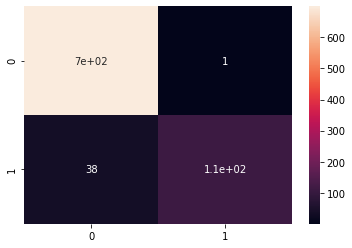

In [41]:
conf = confusion_matrix(y_test, y_preds)
sns.heatmap(conf,
           annot = True);
print(conf)

## Accuracy score

In [42]:
print(accuracy_score(y_test, y_preds))

0.9541176470588235


**We can see the model is performing well with `95 %` accuracy**

## Plot roc curve

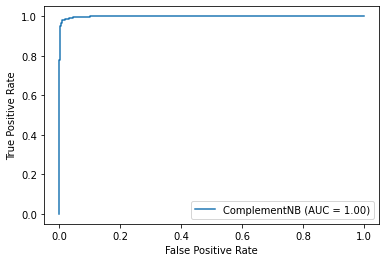

In [43]:
plot_roc_curve(model2, X, y);

# Saving Model

In [44]:
import joblib
joblib.dump(model2, 'Spam-mail-classification.pkl')

['Spam-mail-classification.pkl']